# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [1]:
# classics
import numpy as np
import pandas as pd
import random, h5py
import tensorflow as tf
import math

# my tool and sparse stuff for feature extraction
import utils, gcnIO
import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import scipy.sparse as sp

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

# sklearn imports
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import matplotlib.mlab as mlab
plt.rc('font', family='Times New Roman')

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
model_dir = '../data/GCN/training/2018_09_25_12_24_44/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2018_09_25_12_24_44/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels_gefcstandardnorm.h5
{'lr': 0.001, 'epochs': 7000, 'hidden_dims': [50, 40, 30, 20, 10], 'data': '../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels_gefcstandardnorm.h5', 'loss_mul': 30.0, 'cv_runs': 10, 'dropout': 0.5, 'support': 2, 'decay': 0.0005}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [3]:
# load predictions
if os.path.exists(os.path.join(model_dir, 'predictions.tsv')):
    predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'predictions.tsv'),
                                        sep='\t', header=0)
else:
    predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'),
                                        sep='\t', header=0) 
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    nodes = nodes[~nodes.index.duplicated()]
    pred_ordered = predictions[~predictions.index.duplicated()]
    pred_ordered.reindex(index=nodes.index)

predictions.drop([c for c in predictions.columns if c.startswith('Prob_pos')], axis=1, inplace=True)
predictions.columns = ['label', 'Name', 'Num_Pos', 'Prob_pos', 'Std_Pred']
predictions.head()

,label,Name,Num_Pos,Prob_pos,Std_Pred
ID,,,,,
ENSG00000197122,True,SRC,10,1.000,0.000
ENSG00000100393,True,EP300,10,1.000,0.000
ENSG00000005339,True,CREBBP,10,1.000,0.000
ENSG00000116478,False,HDAC1,10,1.000,0.000
ENSG00000141510,True,TP53,10,1.000,0.000


In [4]:
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
print (pred_with_feat.shape)
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['label'] = np.logical_or(train_mask, test_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

(12135, 42)
Predicted 3409 genes of 12129 total to be involved in infection


Correlation of prediction with #neighbors: 0.27582581384133326
Correlation of prediction with #neighbors for positives: 0.18337581910407852


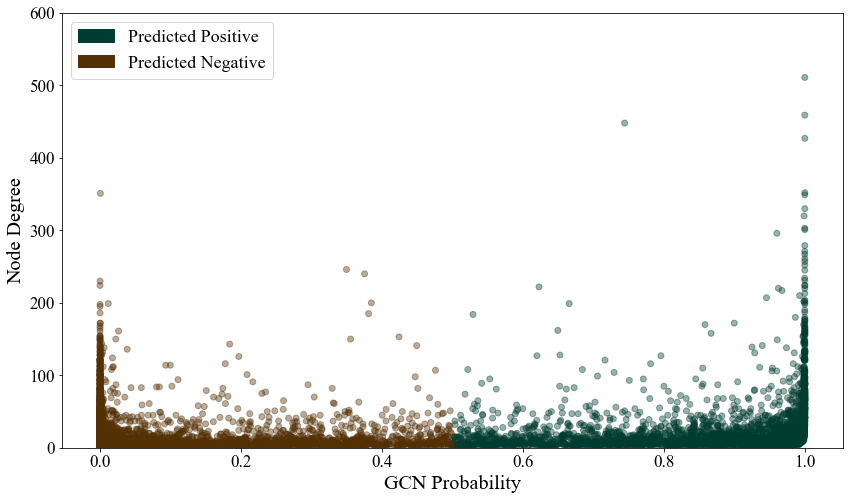

In [5]:
fig = plt.figure(figsize=(14, 8))
cmap = plt.cm.BrBG
plt.scatter(pred_with_feat.Prob_pos, pred_with_feat.neighbors,
            c=pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=cmap, alpha=.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability', fontsize=20)
plt.ylabel('Node Degree', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
pred = mpatches.Patch(color=cmap(1000), label='Predicted Positive')
non_pred = mpatches.Patch(color=cmap(0), label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'))

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [6]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 445 out of 592 known infection genes
Out of these 592, 160 were not shown during training.
Predicted 130 out of 160 test genes (81.25%)
Predicted 315 out of 432 train genes (72.91666666666666%)
Correctly rejected 1697 out of 1980 genes (True Negatives) (85.70707070707071%)
Falsely predicted 283 negatives (FN)


,Name_,positive,training_set,testing_set,label_,negative,label,Name,Num_Pos,Prob_pos,Std_Pred
ENSG00000114166,KAT2B,False,True,False,1,True,False,KAT2B,10,1.000,0.000
ENSG00000158092,NCK1,False,False,True,1,True,False,NCK1,10,1.000,0.000
ENSG00000188612,SUMO2,False,False,True,1,True,False,SUMO2,10,1.000,0.000
ENSG00000134308,YWHAQ,False,True,False,1,True,False,YWHAQ,10,1.000,0.000
ENSG00000143190,POU2F1,False,False,True,1,True,False,POU2F1,10,1.000,0.000
ENSG00000183598,HIST2H3D,False,False,True,1,True,False,HIST2H3D,10,1.000,0.000
ENSG00000078043,PIAS2,False,True,False,1,True,False,PIAS2,10,1.000,0.000
ENSG00000162521,RBBP4,False,True,False,1,True,False,RBBP4,10,1.000,0.000
ENSG00000089902,RCOR1,False,True,False,1,True,False,RCOR1,10,1.000,0.001
ENSG00000185386,MAPK11,False,False,True,1,True,False,MAPK11,10,1.000,0.001


In [7]:
y_true = y_test[test_mask == 1, 0]
y_score = predictions[test_mask == 1].Prob_pos
accuracy_score(y_pred=y_score > 0.5, y_true=y_true)

0.6287769784172662

In [8]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

## Train other Classifiers on the Features for Comparison
In order to evaluate our method, let's compare it's power to other algorithms. For now, I'll focus on ones, that operate on the features alone and algorithms that operate on the network alone.
The comparison is with:
* **SVM classifier**: A very powerful, non-linear method that generally does not really overfit and can deal with little data. This should be an upper bound on what one can reach on the features alone.
* **Logistic regression**: This is a linear algorithm, also only operating on the features. It is less powerful than an SVM.
* **PageRank**: A network ranking method that only computes the most important nodeso in the network. It's completely blind to the features.

In [9]:
X_train = features[train_mask.astype(np.bool)]
y_train_svm = y_train[train_mask.astype(np.bool)]

X_test = features[test_mask.astype(np.bool)]
y_test_svm = y_test[test_mask.astype(np.bool)]

In [10]:
# train random forest on the features only and predict for test set and all genes
rf = RandomForestClassifier()
rf.fit(X_train, y_train_svm.reshape(-1))
pred_rf = rf.predict_proba(X_test)
print ("Number of predicted genes in Test set (RF): {}".format(pred_rf.argmax(axis=1).sum()))
pred_rf_all = rf.predict_proba(features)
print ("RF predicts {} genes in total".format(np.argmax(pred_rf_all, axis=1).sum()))

Number of predicted genes in Test set (RF): 80
RF predicts 1574 genes in total


In [11]:
# train logistic regression on the features only and predict for test set and all genes
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train_svm.reshape(-1))
pred_lr = logreg.predict_proba(X_test)
print ("Number of predicted genes in Test set (LogReg): {}".format(pred_lr.argmax(axis=1).sum()))
pred_lr_all = logreg.predict_proba(features)
print ("LogReg predicts {} genes in total".format(np.argmax(pred_lr_all, axis=1).sum()))

Number of predicted genes in Test set (LogReg): 196
LogReg predicts 3751 genes in total


In [12]:
# train pagerank on the network
scores, names = pagerank.pagerank(network, node_names)
pr_df = pd.DataFrame(scores, columns=['Number', 'Score'])
names = pd.DataFrame(names, columns=['ID', 'Name'])
pr_pred_all = pr_df.join(names, on='Number', how='inner')
pr_pred_all.drop_duplicates(subset='ID', inplace=True)
pr_pred_test = pr_pred_all[pr_pred_all.ID.isin(node_names[test_mask == 1, 0])]

Maximum Pagerank: Index: 11270	Pagerank: 0.006650312418214648
Minimum Pagerank: Index: 3508	Pagerank: 1.503088157884692e-05


In [13]:
# do a random walk with restart and use HotNet2 heat as p_0

# read heat json from file
heat_df = pd.read_json('../../hotnet2/heat_syn_cnasnv.json').drop('parameters', axis=1)
heat_df.dropna(axis=0, inplace=True)

# join with node names to get correct order and only genes present in network
nn = pd.DataFrame(node_names, columns=['ID', 'Name'])
heat_df = nn.merge(heat_df, left_on='Name', right_index=True, how='left')
heat_df.fillna(0, inplace=True)

# add normalized heat
heat_df['heat_norm'] = heat_df.heat / heat_df.heat.sum()

p_0 = heat_df.heat_norm
p_0 = features.mean(axis=1)

In [14]:
beta = 0.3
W = network / network.sum(axis=0) # normalize A
assert (np.allclose(W.sum(axis=0), 1)) # assert that rows/cols sum to 1

p = np.linalg.inv(beta * (np.eye(network.shape[0]) - (1 - beta) * W)).dot(np.array(p_0))
rwr_ranks = np.argsort(p)[::-1]
heat_df['rwr_score'] = p
rwr_pred_test = heat_df[test_mask == 1].rwr_score

ACCURACY: 0.6402877697841727


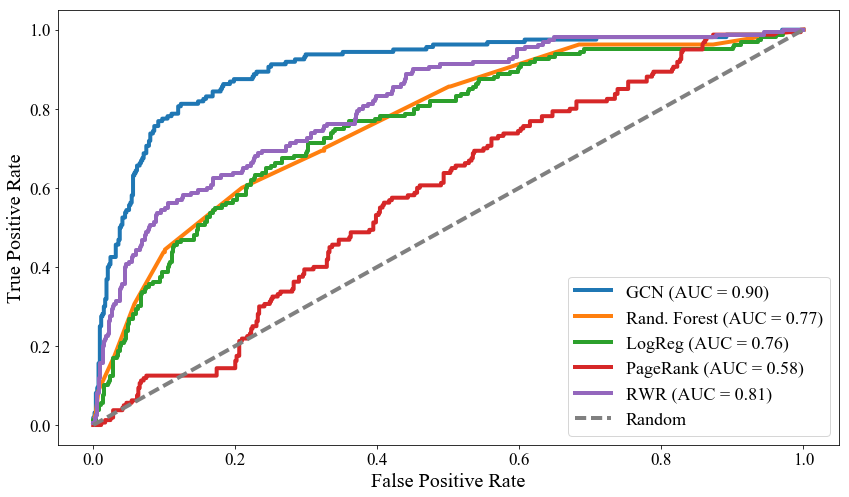

In [15]:
linewidth = 4
labelfontsize = 20
ticksize = 17
#y_score = predictions.Prob_pos
#y_true = np.logical_or(y_train, y_test)
y_true = y_test[test_mask == 1, 0]
pred_testset_gcn = predictions[predictions.Name.isin(node_names[test_mask, 1])]
y_true_gcn = pred_testset_gcn.label
y_score = pred_testset_gcn.Prob_pos
fpr, tpr, thresholds = roc_curve(y_true=y_true_gcn, y_score=y_score)
roc_auc = roc_auc_score(y_true=y_true_gcn, y_score=y_score)

# compute roc for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true=y_true, y_score=pred_rf[:, 1])
roc_auc_rf = roc_auc_score(y_true=y_true, y_score=pred_rf[:, 1])

# compute ROC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=y_true, y_score=pred_lr[:, 1])
roc_auc_lr = roc_auc_score(y_true=y_true, y_score=pred_lr[:, 1])

# compute ROC for PageRank
fpr_pr, tpr_pr, thresholds_pr = roc_curve(y_true=y_true, y_score=pr_pred_test.Score)
roc_auc_pr = roc_auc_score(y_true=y_true, y_score=pr_pred_test.Score)

# compute ROC for RWR with HotNet2 heat scores
fpr_hotnet, tpr_hotnet, thresholds_hotnet = roc_curve(y_true=y_true, y_score=rwr_pred_test)
roc_auc_hotnet = roc_auc_score(y_true=y_true, y_score=rwr_pred_test)

# plot ROC curve
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=linewidth, label='GCN (AUC = {0:.2f})'.format(roc_auc))
plt.plot(fpr_rf, tpr_rf, lw=linewidth, label='Rand. Forest (AUC = {0:.2f})'.format(roc_auc_rf))
plt.plot(fpr_lr, tpr_lr, lw=linewidth, label='LogReg (AUC = {0:.2f})'.format(roc_auc_lr))
plt.plot(fpr_pr, tpr_pr, lw=linewidth, label='PageRank (AUC = {0:.2f})'.format(roc_auc_pr))
plt.plot(fpr_hotnet, tpr_hotnet, lw=linewidth, label='RWR (AUC = {0:.2f})'.format(roc_auc_hotnet))
plt.plot([0, 1], [0, 1], color='gray', lw=linewidth, linestyle='--', label='Random')
plt.xlabel('False Positive Rate', fontsize=labelfontsize)
plt.ylabel('True Positive Rate', fontsize=labelfontsize)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('ROC Curve')
plt.legend(loc='lower right', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'roc_curve.svg'))
acc = accuracy_score(y_true=y_true,
                     y_pred=y_score >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

In [16]:
distances = np.sqrt(np.sum((np.array([0, 1]) - np.array([fpr, tpr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold

Optimal classification threshold: 0.5130057542715589


0.2302158273381295 160 535


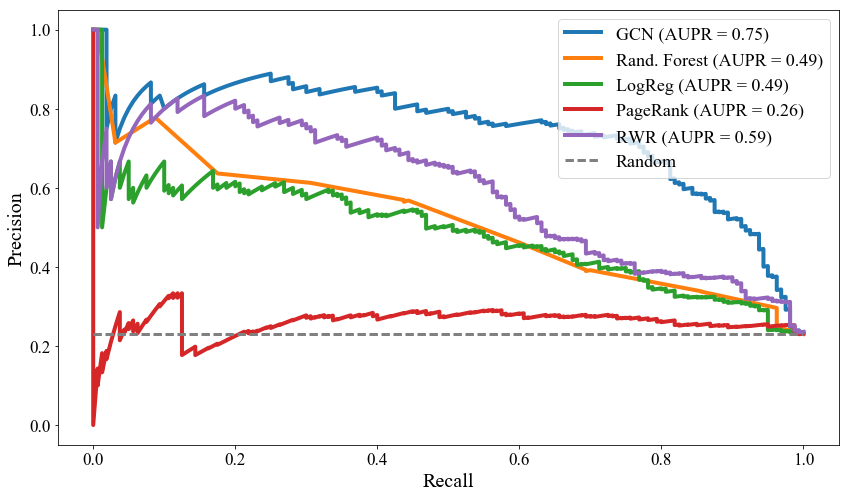

In [17]:
linewidth = 4
labelfontsize = 20
ticksize = 17
# calculate precision and recall for GCN
pr, rec, thresholds = precision_recall_curve(y_true=y_true_gcn, probas_pred=y_score)
aupr = average_precision_score(y_true=y_true_gcn, y_score=y_score)

# calculate precision and recall for RF
pr_rf, rec_rf, thresholds_rf = precision_recall_curve(y_true=y_true, probas_pred=pred_rf[:, 1])
aupr_rf = average_precision_score(y_true=y_true, y_score=pred_rf[:, 1])

# calculate precision and recall for Logistic Regression
pr_lr, rec_lr, thresholds_lr = precision_recall_curve(y_true=y_true, probas_pred=pred_lr[:, 1])
aupr_lr = average_precision_score(y_true=y_true, y_score=pred_lr[:, 1])

# calculate precision and recall for PageRank
pr_pr, rec_pr, thresholds_pr = precision_recall_curve(y_true=y_true, probas_pred=pr_pred_test.Score)
aupr_pr = average_precision_score(y_true=y_true, y_score=pr_pred_test.Score)

# calculate precision and recall for Hotnet2
pr_hotnet, rec_hotnet, thresholds_hotnet = precision_recall_curve(y_true=y_true, probas_pred=rwr_pred_test)
aupr_hotnet = average_precision_score(y_true=y_true, y_score=rwr_pred_test)

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=linewidth, label='GCN (AUPR = {0:.2f})'.format(aupr))
#plt.plot(rec_svm, pr_svm, lw=linewidth, label='SVM (AUPR = {0:.2f})'.format(aupr_svm))
plt.plot(rec_rf, pr_rf, lw=linewidth, label='Rand. Forest (AUPR = {0:.2f})'.format(aupr_rf))
plt.plot(rec_lr, pr_lr, lw=linewidth, label='LogReg (AUPR = {0:.2f})'.format(aupr_lr))
plt.plot(rec_pr, pr_pr, lw=linewidth, label='PageRank (AUPR = {0:.2f})'.format(aupr_pr))
plt.plot(rec_hotnet, pr_hotnet, lw=linewidth, label='RWR (AUPR = {0:.2f})'.format(aupr_hotnet))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('Precision-Recall Curve')
plt.legend(loc='upper right', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'prec_recall.svg'))
fig.savefig(os.path.join(model_dir, 'prec_recall.png'), dpi=300)
#pr, rec

In [18]:
distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold


Optimal classification threshold: 0.7124441742897034


## Investigate New Model GCN Parameters

In [297]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)

Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../data/GCN/training/2018_08_16_17_46_11/model.ckpt


In [296]:
tf.reset_default_graph()
adj = csr_matrix(network)
num_nodes = adj.shape[0]
num_feat = features.shape[1]
if num_feat > 1:
    F = utils.preprocess_features(lil_matrix(features))
else:
    print("Not row-normalizing features because feature dim is {}".format(num_feat))
    F = gcn.utils.sparse_to_tuple(lil_matrix(features))
print (args)
poly_support = args['support']
if poly_support > 0:
    support = utils.chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else: # support is 0, don't use the network
    support = [sp.eye(adj.shape[0])]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])
print (y_train.shape)
print (features.shape)

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = gcn.utils.construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      hidden_dims=args['hidden_dims'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      num_hidden_layers=len(args['hidden_dims']),
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = gcn.utils.construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices), len(support)

{'lr': 0.001, 'support': 2, 'loss_mul': 30.0, 'decay': 0.0005, 'data': '../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5', 'hidden_dims': [50, 40, 30, 20, 10], 'dropout': 0.4, 'cv_runs': 10, 'epochs': 7000}
Calculating Chebyshev polynomials up to order 2...
3
[(12129, 12129), (12129, 12129), (12129, 12129)]
(12129, 1)
(12129, 35)


AttributeError: 'NoneType' object has no attribute 'model_checkpoint_path'

## Plot TSNE at all layers

In [291]:
pos_classified = labels_with_pred.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
labels_with_pred['color'] = 'gray'
labels_with_pred.loc[pos_classified, 'color'] = 'red'
labels_with_pred.loc[~labels_with_pred.label & pos_classified, 'color'] = 'green'
labels_with_pred.groupby('color').count()

,Name_,positive,training_set,testing_set,label_,negative,label,Name,Num_Pos,Prob_pos,Std_Pred
color,,,,,,,,,,,
gray,8844,8844,8844,8844,8844,8844,8844,8844,8844,8844,8844
green,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770
red,521,521,521,521,521,521,521,521,521,521,521


In [292]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

NameError: name 'activations' is not defined

In [ ]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)